In [1]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from math import *
import matplotlib.animation as animation

# ヤコビ行列の逆行列を求める
def calc_yacobian_inv(phi1, phi2, l1, l2):
    yacobian = np.array([[-l1*sin(phi1) - l2*sin(phi1+phi2),-l2*sin(phi1+phi2)],
                         [l1*cos(phi1) + l2*cos(phi1+phi2),l2*cos(phi1+phi2)]])
    try:
        yacobian_inv = np.linalg.inv(yacobian) #ヤコビ行列の逆行列を求める
    except:
        yacobian_inv = np.linalg.pinv(yacobian) #正則で求められないとき疑似逆行列を求める

    return yacobian_inv

# 追従させる軌道 直線 端点の2つの座標を与える.  binは時間の分割数. 各時刻における所望の座標のリストを返す(indexは分割数個)
def calc_line_coodinate_bytime(start, end, req_t):
    cur_t = 0
    x_refs = []
    y_refs = []
    while(cur_t < req_t):
        s = 6*(cur_t/req_t)**5 - 15*(cur_t/req_t)**4 + 10*(cur_t/req_t)**3
        x_ref = start[0]*(1-s) + end[0]*s
        y_ref = start[1]*(1-s) + end[1]*s
        x_refs.append(x_ref)
        y_refs.append(y_ref)
        cur_t += 1
    
    return x_refs, y_refs

# 順運動学で第一関節の位置を計算
def calc_cur_first_pos(l1,phi1):
    x = l1*cos(phi1)
    y = l1*sin(phi1)
    cur_first_pos = [x,y]

    return cur_first_pos

# 順運動学で第二関節の位置を計算
def calc_cur_hand_pos(l1,l2,phi1,phi2):
    x = l1*cos(phi1) + l2*cos(phi1+phi2)
    y = l1*sin(phi1) + l2*sin(phi1+phi2)
    cur_hand_pos = np.array([[x],
                             [y]])

    return cur_hand_pos

# 加える関節角度Φ1,Φ2を求める cur_posは2×1行列 [x,y] (numpy_array)
def calc_added_angle(cur_pos, x_refs, y_refs, index, yacobian_inv):
    goal_pos = np.array([[x_refs[index]],
                         [y_refs[index]]])
    dif_pos = goal_pos - cur_pos # 現在位置との差
    added_angles = np.dot(yacobian_inv, dif_pos) # 加えるべき関節角度の配列

    return added_angles

<IPython.core.display.Javascript object>


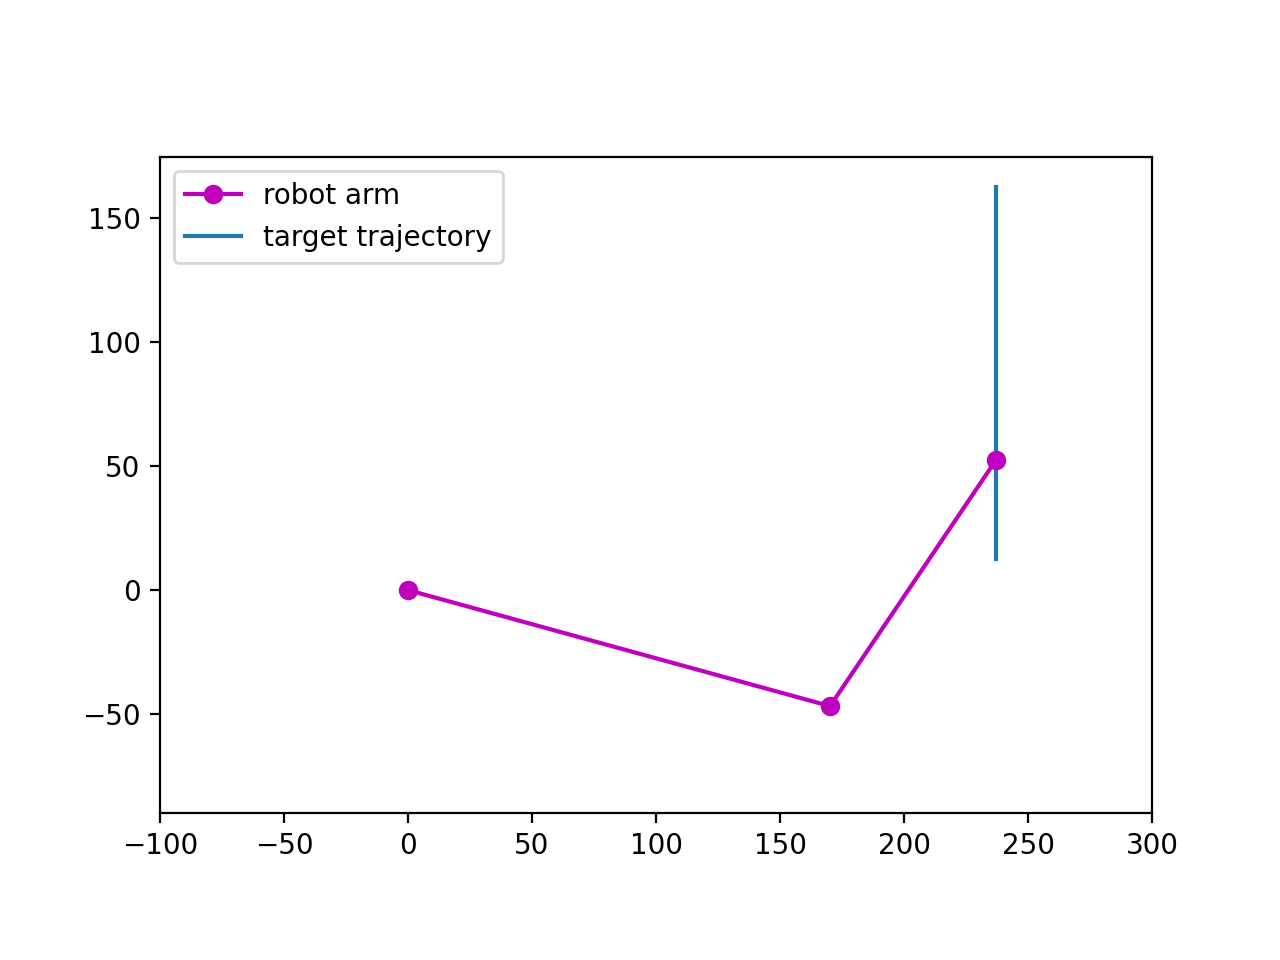

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


done


In [3]:
# params
phi1 = 0.4
phi2 = 0.5

# リンクの長さ
l1 = 83 + 93.5
l2 = 120

# 初期位置
cur_hand_pos = calc_cur_hand_pos(l1,l2,phi1,phi2)

# 直線軌道用
start = [cur_hand_pos[0][0], cur_hand_pos[1][0]]
end = [cur_hand_pos[0][0], cur_hand_pos[1][0] - 150]

req_t = 1000
x_refs, y_refs = calc_line_coodinate_bytime(start,end,req_t)

# 描画用
ims = []
fig = plt.figure()
flag_legend = True

# iteration
for i in range(req_t):
    #print(i)
    # 各関節の現在位置を計算
    cur_first_pos = calc_cur_first_pos(l1,phi1)
    cur_hand_pos = calc_cur_hand_pos(l1,l2,phi1,phi2)
    
    # 目標値との誤差  1で初期化
    error1 = 1
    error2 = 1
    while (abs(error1) > 1e-4 or abs(error2) > 1e-4):
        # ヤコビ行列を計算し、関節を追加する
        yacobian_inv = calc_yacobian_inv(l1,l2,phi1,phi2)
        added_angles = calc_added_angle(cur_hand_pos, x_refs, y_refs, i, yacobian_inv)
        
        # チューニングゲイン
        K = 0.5
        phi1 += K*added_angles[0][0]
        phi2 += K*added_angles[1][0]
        
        cur_hand_pos = calc_cur_hand_pos(l1,l2,phi1,phi2)
        error1 = x_refs[i] - cur_hand_pos[0][0]
        error2 = y_refs[i] - cur_hand_pos[1][0]
        
    """
    if i < 10:
        print("x_dif : " + str(x_refs[i]-cur_hand_pos[0][0]))
        print("y_dif : " + str(y_refs[i]-cur_hand_pos[1][0]))
        print("angle1 : " + str(added_angles[0][0]))
        print("angle2 : " + str(added_angles[1][0]))
    """
    
    #プロット用 遅くなるので5回に1回表示
    im = plt.plot([0,cur_first_pos[0],cur_hand_pos[0][0]],[0,cur_first_pos[1],cur_hand_pos[1][0]],'b-o',label="robot arm",color="m")
    ims.append(im)
    
    if flag_legend: # 一回のみ凡例を描画
        plt.plot(x_refs,y_refs,label="target trajectory")
        #plt.ylim(-2,2)
        plt.xlim(-100,300)
        plt.axes().set_aspect('equal')
        plt.legend()
        flag_legend = False


ani = animation.ArtistAnimation(fig, ims, interval=1)
#ani.save('yacobi_circle_compliance_2link.gif', writer='pillow', fps=50)
fig.show()
print("done")